In [ ]:
#import libraries
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading the avaiable data set
data_biomass = pd.read_csv('/content/drive/MyDrive/dataset/dataset/Biomass_History.csv')
data_dist = pd.read_csv('/content/drive/MyDrive/dataset/dataset/Distance_Matrix.csv')

In [ ]:
def get_biomass_df(file_path):
    df_biomass=pd.read_csv(file_path)
    df_biomass["flag"]=0
    df_biomass.loc[df_biomass["2013"]==df_biomass["2014"],"flag"]=1

    for row in df_biomass.itertuples():
        if row.flag==1:
            df_biomass.loc[row.Index,"2010"]=np.nan
            df_biomass.loc[row.Index,"2011"]=row._4
            df_biomass.loc[row.Index,"2012"]=row._5
            df_biomass.loc[row.Index,"2013"]=np.nan

    df_biomass=df_biomass.drop(columns=["flag"])
    df_biomass=df_biomass.melt(id_vars=["Index","Longitude","Latitude"],var_name="year",value_name="biomass")
    df_biomass["biomass"]=df_biomass.groupby(["Index"])["biomass"].transform(lambda x:x.interpolate().fillna(method="bfill"))
    df_biomass=pd.pivot(df_biomass,index=["Index","Longitude","Latitude"],columns=["year"])

    df_biomass.columns=[c[1] for c in df_biomass.columns]


    return df_biomass.reset_index()

In [ ]:
df_biomass = get_biomass_df('/content/drive/MyDrive/dataset/dataset/Biomass_History.csv')

In [ ]:
df_biomass.head()

,Index,Longitude,Latitude,2010,2011,2012,2013,2014,2015,2016,2017
0,0,71.33144,24.66818,8.475744,8.868568,9.202181,6.023070,10.788374,6.647325,7.387925,5.180296
1,1,71.41106,24.66818,24.029778,28.551348,25.866415,21.634459,34.419411,27.361908,40.431847,42.126945
2,2,71.49069,24.66818,44.831635,66.111168,56.982258,53.003735,70.917908,42.517117,59.181629,73.203232
3,3,71.57031,24.66818,59.974419,80.821304,78.956543,63.160561,93.513924,70.203171,74.536720,101.067352
4,4,71.64994,24.66818,14.653370,19.327524,21.928144,17.899586,19.534035,19.165791,16.531315,26.086885


In [ ]:
def create_map(file_path):

    #read shapefile as df
    shapefile = gpd.read_file(file_path)

    shapefile=shapefile[shapefile["statename"]=="Gujarat"]

    shapefile=shapefile.replace({'distname': {"Batod":"Botad",'Aravali':'Aravalli','Sabar Kantha':'Sabar kantha',
                                            'Gir Somnath':'Gir somnath','Devbhumi Dwarka':'Devbhumi dwarka',
                                            'Banas Kantha':'Banas kantha','Panch Mahals':'Panch mahals',
                                            'Chhota Udaipur':'Chhotaudepur',"The Dangs":"Dang"}})


    #assign each index to a district

    df=df_biomass.copy()

    for row1 in df.itertuples():
        offset=0.03
        longitude=row1.Longitude
        latitude=row1.Latitude
        point_b_left = geometry.Point(longitude-offset, latitude-offset)
        point_t_right = geometry.Point(longitude+offset, latitude+offset)
        point_t_left = geometry.Point(longitude-offset, latitude+offset)
        point_b_right = geometry.Point(longitude+offset, latitude-offset)

        for row2 in shapefile.itertuples():
            polygon=row2.geometry
            if polygon.contains(point_b_left) and polygon.contains(point_t_right) and polygon.contains(point_t_left) and polygon.contains(point_b_right):
                df.loc[row1.Index,"distname"]=row2.distname
                break

    print(df.distname.isna().sum()," not assigned to a district")

    return df

In [ ]:
def add_biomass_prod(df_map,df_biomass):
    df_sum=pd.DataFrame()
    drop_cols=["2010","2011","2012","2013","2014","2015","2016","2017"]
    df=df_map.copy()
    df=df.drop(columns=drop_cols)

    for y in range(2010,2020):
        df["year"]=y
        try:
            df["biomass"]=df_biomass[str(y)]
        except:
            df["biomass"]=0
        df_sum=pd.concat([df_sum,df])

    print("final shape:",df.shape)
    return df_sum

In [ ]:
def post_process_districts(df):
    df_corr = df.groupby(["distname", "year"])["biomass"].sum().reset_index()
    df_corr = pd.pivot_table(df_corr, values='biomass', index='year', columns='distname')

    for g, group in df.groupby("Index"):
        group_corr = df_corr.corrwith(group.set_index('year')['biomass'])
        sorted_corr = group_corr.sort_values(ascending=False)
        district_to_assign = sorted_corr.index[-2] if len(sorted_corr) >= 2 else None

        if district_to_assign:
            df.loc[df["Index"] == g, "distname"] = district_to_assign

    print(df.distname.isna().sum(), "not assigned to a district")

    df.plot(kind="scatter", x="Longitude", y="Latitude", c=df.distname.astype("category").cat.codes, cmap="rainbow")

    return df
# def post_process_ditricts(df):
#     for t in range(5):
#         for i in range(5):
#             for row in df.itertuples():
#                 if pd.isnull(row.distname):


#                     longitude=row.Longitude
#                     latitude=row.Latitude
#                     input=[longitude,latitude]



#                     df_closest=df.iloc[(df[['Longitude',"Latitude"]]-input).abs().mean(axis=1).sort_values().index[1+t]]

#                     if not pd.isnull(df_closest.distname):
#                         df.loc[row.Index,"distname"]=df_closest.distname

#     print(df.distname.isna().sum()," not assigned to a district")

#     return df


In [ ]:
from matplotlib import pyplot
import geopandas as gpd
from shapely import geometry

800  not assigned to a district
final shape: (2418, 6)
0 not assigned to a district


,Index,Longitude,Latitude,distname,year,biomass
0,0,71.33144,24.66818,Amreli,2010,8.475744
1,1,71.41106,24.66818,Rajkot,2010,24.029778
2,2,71.49069,24.66818,Dang,2010,44.831635
3,3,71.57031,24.66818,Junagadh,2010,59.974419
4,4,71.64994,24.66818,Amreli,2010,14.653370


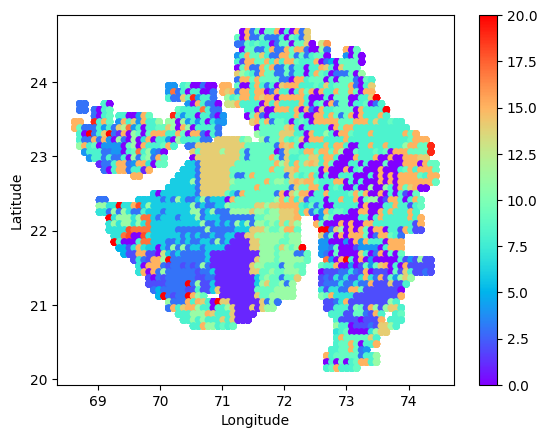

In [ ]:
df_map= create_map('/content/drive/MyDrive/dataset/dataset/districts/output.shp')
df_map= add_biomass_prod(df_map,df_biomass)
df_map= post_process_districts(df_map)
df_map.head()

In [ ]:
import os

keep_crop=["Sugarcane",
       'Bajra', 'Castor seed',
       'Cotton(lint)', 'Arhar/Tur',
        'Gram', 'Groundnut',
        'Jowar', 'Maize',
       'Moong(Green Gram)',
         'Rapeseed &Mustard',
       'Rice', 'Sesamum',
       'Soyabean',  'Tobacco',
       'Wheat']

sum_districts=[["Aravalli",'Sabar kantha'],
    ["Botad",'Ahmadabad','Bhavnagar'],
    ['Chhotaudepur','Vadodara'],
    ['Kheda','Mahisagar','Panch mahals'],
    ['Morbi','Rajkot','Surendranagar','Jamnagar',"Devbhumi dwarka"],
    ['Gir somnath','Junagadh'] ]

def process_df(df):
    df_s=df.copy()

    crop_name=df_s.columns[0][0][6:]


    df_s.columns=[c[1]+"_"+c[2] for c in df_s.columns ]
    df_s=df_s[df_s["State_State"]=="Gujarat"]

    df_s=df_s.melt(id_vars=['S.No._S.No.', 'State_State', 'District_District'])
    df_s["year"]=df_s["variable"].str[:4].astype("int")
    df_s["crop"]=crop_name
    df_s=df_s.drop(columns=['S.No._S.No.', 'State_State', 'variable'])
    df_s.columns=["distname","production","year","crop_type"]
    return df_s

def generate_crop_df(root_folder):
    df_all = pd.DataFrame()

    for f in os.listdir(root_folder):
        try:
            # Specify encoding parameter when reading HTML file
            df_raw = pd.read_html(root_folder + f, encoding='ISO-8859-1')
            df = process_df(df_raw[0])

            df_all = pd.concat([df_all, df])
        except UnicodeDecodeError as e:
            print(f"Error reading file {f}: {e}")

    df_pivot = pd.pivot(df_all, columns=["crop_type", "distname"], index=["year"])
    df_pivot.columns = [str(c[1]) + "-" + str(c[2]) for c in df_pivot.columns.to_flat_index()]

    return df_pivot


def filter_crop(df):

    return df[[c for c in df.columns if c.split("-")[0] in keep_crop]]


"""
def impute_dataset(df):
    return df.fillna(0)

"""
def impute_dataset(df):

    district_to_impute = [item for sublist in sum_districts for item in sublist]
    df_impute=df[[c for c in df.columns if c.split("-")[1] in district_to_impute]].copy()

    for crop in keep_crop:
        for s in sum_districts:
            relevant_cols=[crop+"-"+c for c in s ]

            for col in relevant_cols:
                if col not in df_impute.columns:
                    df_impute.loc[:,col]=0
            df_impute.loc[:,"sum_"+s[0]+"-"+s[1]+"-"+crop]=df_impute[relevant_cols].sum(axis=1)

    X_train=df_impute[(df_impute.index>2013)]
    X_pred=df_impute[df_impute.index<2014]

    for crop in keep_crop:
        for s in sum_districts:
            for district in s:
                share=(X_train[crop+"-"+district]/X_train["sum_"+s[0]+"-"+s[1]+"-"+crop]).mean()
                X_pred.loc[:,crop+"-"+district]=share*X_pred["sum_"+s[0]+"-"+s[1]+"-"+crop]

    df_reconstructed=pd.concat([X_train,X_pred]).sort_index()

    for c in df_reconstructed.columns:
        if "sum" in c:continue
        df.loc[:,c]=df_reconstructed.loc[:,c]

    return df



def unpivot(df_crop):
    df=df_crop.reset_index().melt(id_vars=["year"],value_name="production")
    df["distname"]=df["variable"].str.split("-").str[1]
    df["crop_type"]=df["variable"].str.split("-").str[0]
    df=df.drop(columns=["variable"])

    print("final shape:",df.shape)

    return df

In [ ]:
root_folder="/content/drive/MyDrive/dataset/dataset/desagri_all/"
df_crop=generate_crop_df(root_folder)
df_crop=filter_crop(df_crop)
df_crop=impute_dataset(df_crop)
df_crop=unpivot(df_crop)
df_crop.head(10)

<ipython-input-12-77e579198cf9>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_impute.loc[:,"sum_"+s[0]+"-"+s[1]+"-"+crop]=df_impute[relevant_cols].sum(axis=1)
<ipython-input-12-77e579198cf9>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_impute.loc[:,col]=0
<ipython-input-12-77e579198cf9>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

final shape: (5456, 4)


,year,production,distname,crop_type
0,2010,43700.0,Kachchh,Moong(Green Gram)
1,2011,40900.0,Kachchh,Moong(Green Gram)
2,2012,9500.0,Kachchh,Moong(Green Gram)
3,2013,32964.0,Kachchh,Moong(Green Gram)
4,2014,15927.0,Kachchh,Moong(Green Gram)
5,2015,35075.0,Kachchh,Moong(Green Gram)
6,2016,29135.0,Kachchh,Moong(Green Gram)
7,2017,39838.0,Kachchh,Moong(Green Gram)
8,2018,2412.0,Kachchh,Moong(Green Gram)
9,2019,41934.0,Kachchh,Moong(Green Gram)


In [ ]:
df_elev=pd.read_csv("/content/drive/MyDrive/dataset/dataset/wc2.1_30s_elev.csv").rename({"mean":"elevation"},axis=1).fillna(0) #some nan values on the borders
df_elev.head()

,min,max,count,elevation,year,month,type,index,lat,long
0,8.0,13.0,100,11.010000,0s_e,ev,2.1_,0,24.66818,71.33144
1,12.0,28.0,90,15.377778,0s_e,ev,2.1_,1,24.66818,71.41106
2,15.0,37.0,100,24.220000,0s_e,ev,2.1_,2,24.66818,71.49069
3,24.0,46.0,90,33.200000,0s_e,ev,2.1_,3,24.66818,71.57031
4,30.0,53.0,100,43.340000,0s_e,ev,2.1_,4,24.66818,71.64994


In [ ]:
df_cropland=pd.read_csv("/content/drive/MyDrive/dataset/dataset/Global_cropland_3km_2019.csv").rename({"mean":"cropland"},axis=1).fillna(0) #some nan values on the borders
df_cropland.head()

,min,max,count,cropland,majority,median,std,sum,minority,range,year,month,type,index,biomass,lat,long
0,0.0,13.0,9,4.555556,0.0,2.0,5.057692,41.0,2.0,13.0,tif,0.0,al_c,0,5.180296,24.66818,71.33144
1,8.0,90.0,9,30.000000,11.0,20.0,25.542992,270.0,8.0,82.0,tif,0.0,al_c,1,42.126945,24.66818,71.41106
2,29.0,92.0,9,74.000000,29.0,79.0,18.938497,666.0,29.0,63.0,tif,0.0,al_c,2,73.203232,24.66818,71.49069
3,79.0,93.0,9,86.111111,81.0,85.0,4.931631,775.0,79.0,14.0,tif,0.0,al_c,3,101.067352,24.66818,71.57031
4,79.0,99.0,12,88.000000,81.0,88.0,6.258328,1056.0,79.0,20.0,tif,0.0,al_c,4,26.086885,24.66818,71.64994


In [ ]:
def create_final_dataset(df_map,df_crop,df_elev,df_cropland):

    df_merged=df_map.merge(df_crop,left_on=["distname","year"],right_on=["distname","year"],how="left")
    df_merged=df_merged.merge(df_elev[["index","elevation"]],left_on=["Index"],right_on=["index"],how="left").drop(columns=["index"])
    df_merged=df_merged.merge(df_cropland[["index","cropland"]],left_on=["Index"],right_on=["index"],how="left").drop(columns=["index"])


    df_pivot=pd.pivot_table(df_merged,columns=["crop_type"],index=["Index","Longitude","Latitude","distname","biomass","year","elevation","cropland"])
    df_pivot.columns = [ c[0]+"-"+str(c[1]) for c in df_pivot.columns.to_flat_index()]
    df_pivot=df_pivot.reset_index()

    df_pivot=df_pivot.fillna(0) #Nan means no prod

    print("final shape:",df_pivot.shape)

    return df_pivot

def add_features(df):

    cat_dict=dict( enumerate(df["distname"].astype("category").cat.categories ) )
    df["distname"]=df["distname"].astype("category").cat.codes


    print(cat_dict)

    for c in df.distname.unique():
        df["in_district_"+str(c)]=np.where(df["distname"]==c,1,0)


    df["total_crop_prod"]=df[[c for c in df.columns if "production" in c]].sum(axis=1)
    df["count_district"]=df.groupby(["distname"])["total_crop_prod"].transform(lambda x:x.count())

    df["index_cotton_prod_share"]=df["production-Cotton(lint)"]/df["count_district"]

    for c in ["production-Cotton(lint)"]:

        df["district_prod_"+c+"_sum"]=df.groupby(["distname","year"])[c].transform(lambda x:x.sum())

    df["log_biomass"]=np.log10(df["biomass"]+1e-5)

    return df

In [ ]:
df_final=create_final_dataset(df_map,df_crop,df_elev,df_cropland)
df_final=add_features(df_final)

df_final.head()

final shape: (24180, 24)
{0: 'Amreli', 1: 'Anand', 2: 'Botad', 3: 'Dang', 4: 'Devbhumi dwarka', 5: 'Dohad', 6: 'Gandhinagar', 7: 'Gir somnath', 8: 'Jamnagar', 9: 'Junagadh', 10: 'Kachchh', 11: 'Narmada', 12: 'Panch mahals', 13: 'Patan', 14: 'Porbandar', 15: 'Rajkot', 16: 'Sabar kantha', 17: 'Surat', 18: 'Surendranagar', 19: 'Tapi', 20: 'Valsad'}


,Index,Longitude,Latitude,distname,biomass,year,elevation,cropland,production-Arhar/Tur,production-Bajra,...,in_district_12,in_district_1,in_district_6,in_district_18,in_district_10,total_crop_prod,count_district,index_cotton_prod_share,district_prod_production-Cotton(lint)_sum,log_biomass
0,0,71.33144,24.66818,0,0.000000,2018,11.01,4.555556,2454.0,5768.0,...,0,0,0,0,0,666889.0,2690,205.437918,148656932.0,-5.000000
1,0,71.33144,24.66818,0,0.000000,2019,11.01,4.555556,3068.0,16393.0,...,0,0,0,0,0,1991530.0,2690,545.349071,394620041.0,-5.000000
2,0,71.33144,24.66818,0,5.180296,2017,11.01,4.555556,2642.0,7953.0,...,0,0,0,0,0,1095213.0,2690,310.411524,224616883.0,0.714355
3,0,71.33144,24.66818,0,6.023070,2013,11.01,4.555556,1057.0,10030.0,...,0,0,0,0,0,2458662.0,2690,711.905948,515142263.0,0.779819
4,0,71.33144,24.66818,0,6.647325,2015,11.01,4.555556,912.0,6399.0,...,0,0,0,0,0,1323761.0,2690,394.115985,285186268.0,0.822648


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler,StandardScaler,MinMaxScaler,RobustScaler,PowerTransformer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor,AdaBoostRegressor,RandomForestClassifier,StackingRegressor,VotingRegressor
from sklearn.metrics import mean_absolute_error,auc,roc_curve
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso, HuberRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Extra Tree Regressor

In [ ]:
def train_model_log(df):


    params = {
        'random_state': 42,
            "n_estimators":100,
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Step 1: Scale the data
        ('regressor', ExtraTreesRegressor(**params))  # Step 2: Train ExtraTreesRegressor
    ])

    results=pd.DataFrame()
    tot_mae=[]
    for y in [2010,2011,2012,2013,2014,2015,2016,2017]:

        df_train=df.loc[(~df.year.isin([2018,2019,y]))&(df["biomass"]),:]
        df_test=df.loc[df.year==y,:]

        X_train=df_train.drop(columns=["log_biomass","biomass","year"])
        y_train=df_train[["log_biomass"]].values.ravel()

        X_test=df_test.drop(columns=["log_biomass","biomass","year"])
        y_test=df_test[["log_biomass"]].values.ravel()

        pipeline.fit(X_train,y_train)

        mae_test=np.abs(10**pipeline.predict(X_test)-10**y_test).mean()
        mae_train=np.abs(10**pipeline.predict(X_train)-10**y_train).mean()
        tot_mae+=[(y,mae_train,mae_test)]
        print(y,mae_train,mae_test)


        df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
        df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)
        results=pd.concat([results,df_test])

    sum_df=pd.DataFrame(tot_mae,columns=["year","mae_train","mae_test"]).T
    sum_df["mean"]=sum_df.mean(axis=1)

    print(sum_df)

    return pipeline,results


def generate_predictions(model,df,filename):

    df_train=df.loc[~df.year.isin([2018,2019]),:]

    X_train=df_train.drop(columns=["log_biomass","year","biomass"])
    y_train=df_train[["log_biomass"]].values.ravel()


    model.fit(X_train,y_train)

    X_2018=df[df.year==2018].drop(columns=["log_biomass","year","biomass"])
    X_2019=df[df.year==2019].drop(columns=["log_biomass","year","biomass"])

    y_2018=10**model.predict(X_2018)
    y_2019=10**model.predict(X_2019)

    fig,ax=plt.subplots(1,2,figsize=(20,10))
    X_2018["2018"]=y_2018

    X_2018.plot(kind="scatter",x="Longitude",y="Latitude",c="2018",cmap="rainbow",ax=ax[0],title="2018 forecast: "+str(int(np.sum(y_2018))))

    X_2019["2019"]=y_2019
    X_2019.plot(kind="scatter",x="Longitude",y="Latitude",c="2019",cmap="rainbow",ax=ax[1],title="2019 forecast: "+str(int(np.sum(y_2019))))

    pd.concat([X_2018["2018"].reset_index(),X_2019["2019"].reset_index()],axis=1).drop(columns="index").to_csv(f"../forecast/{filename}")


    return y_2018,y_2019


def add_theo_biomass(df,val_year=None):

    if "theo_biomass" in df.columns:
        df=df.drop(columns=["theo_biomass"])

    params = {
        'random_state': 42,
            "criterion": "log_loss",
            "class_weight":"balanced",
            "n_estimators":100,
    }

    pipeline = LinearRegression()

    prediction_columns = ["production-Cotton(lint)"]


    if val_year is None:
        tot_mae=[]
        for y in [2010,2011,2012,2013,2014,2015,2016,2017]:
            #if y!=2012:continue

            df_train=df.loc[~df.year.isin([2018,2019,y]),:]
            df_test=df.loc[df.year==y,:]

            X_train=df_train[prediction_columns]
            y_train=df_train["biomass"].values.ravel()

            X_test=df_test[prediction_columns]
            y_test=df_test["biomass"].values.ravel()

            pipeline.fit(X_train,y_train)

            mae_test=np.abs(pipeline.predict(X_test)-y_test).mean()
            mae_train=np.abs(pipeline.predict(X_train)-y_train).mean()
            tot_mae+=[(y,mae_train,mae_test)]
            print(y,mae_train,mae_test)




        sum_df=pd.DataFrame(tot_mae,columns=["year","auc_test"]).T
        sum_df["mean"]=sum_df.mean(axis=1)

        print(sum_df)

        df_train=df.loc[~df.year.isin([2018,2019]),:]

        X_train=df_train[prediction_columns]
        y_train=df_train["biomass"].values.ravel()


        pipeline.fit(X_train,y_train)

        df["theo_biomass"]=np.where(df.year.isin([2018,2019]),pipeline.predict(df[prediction_columns]),df["biomass"])


    else:
        df_train=df.loc[~df.year.isin([2018,2019,val_year]),:]

        X_train=df_train[prediction_columns]
        y_train=df_train["biomass"].values.ravel()


        pipeline.fit(X_train,y_train)

        df["theo_biomass"]=np.where(df.year.isin([2018,2019,val_year]),pipeline.predict(df[prediction_columns]),df["biomass"])

    return df

In [ ]:
pipeline,results= train_model_log(df_final)

2010 9.870587022289328e-13 33.11067306203235


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2011 9.775500350501491e-13 37.719095006203574


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2012 1.0278034717355417e-12 53.68355876308596


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2013 9.727135231581364e-13 44.233789996107234


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2014 9.66107642536014e-13 35.5102754768653


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2015 9.982745564352908e-13 29.40917273593575


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2016 1.0168090352476567e-12 44.85114563513936


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2017 9.689210026165268e-13 51.419276925995845


<ipython-input-19-9f2716840146>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-19-9f2716840146>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


                      0             1             2             3  \
year       2.010000e+03  2.011000e+03  2.012000e+03  2.013000e+03   
mae_train  9.870587e-13  9.775500e-13  1.027803e-12  9.727135e-13   
mae_test   3.311067e+01  3.771910e+01  5.368356e+01  4.423379e+01   

                      4             5             6             7  \
year       2.014000e+03  2.015000e+03  2.016000e+03  2.017000e+03   
mae_train  9.661076e-13  9.982746e-13  1.016809e-12  9.689210e-13   
mae_test   3.551028e+01  2.940917e+01  4.485115e+01  5.141928e+01   

                   mean  
year       2.013500e+03  
mae_train  9.894047e-13  
mae_test   4.124212e+01  


File saved at: ../forecast/forecast_extratrees.csv


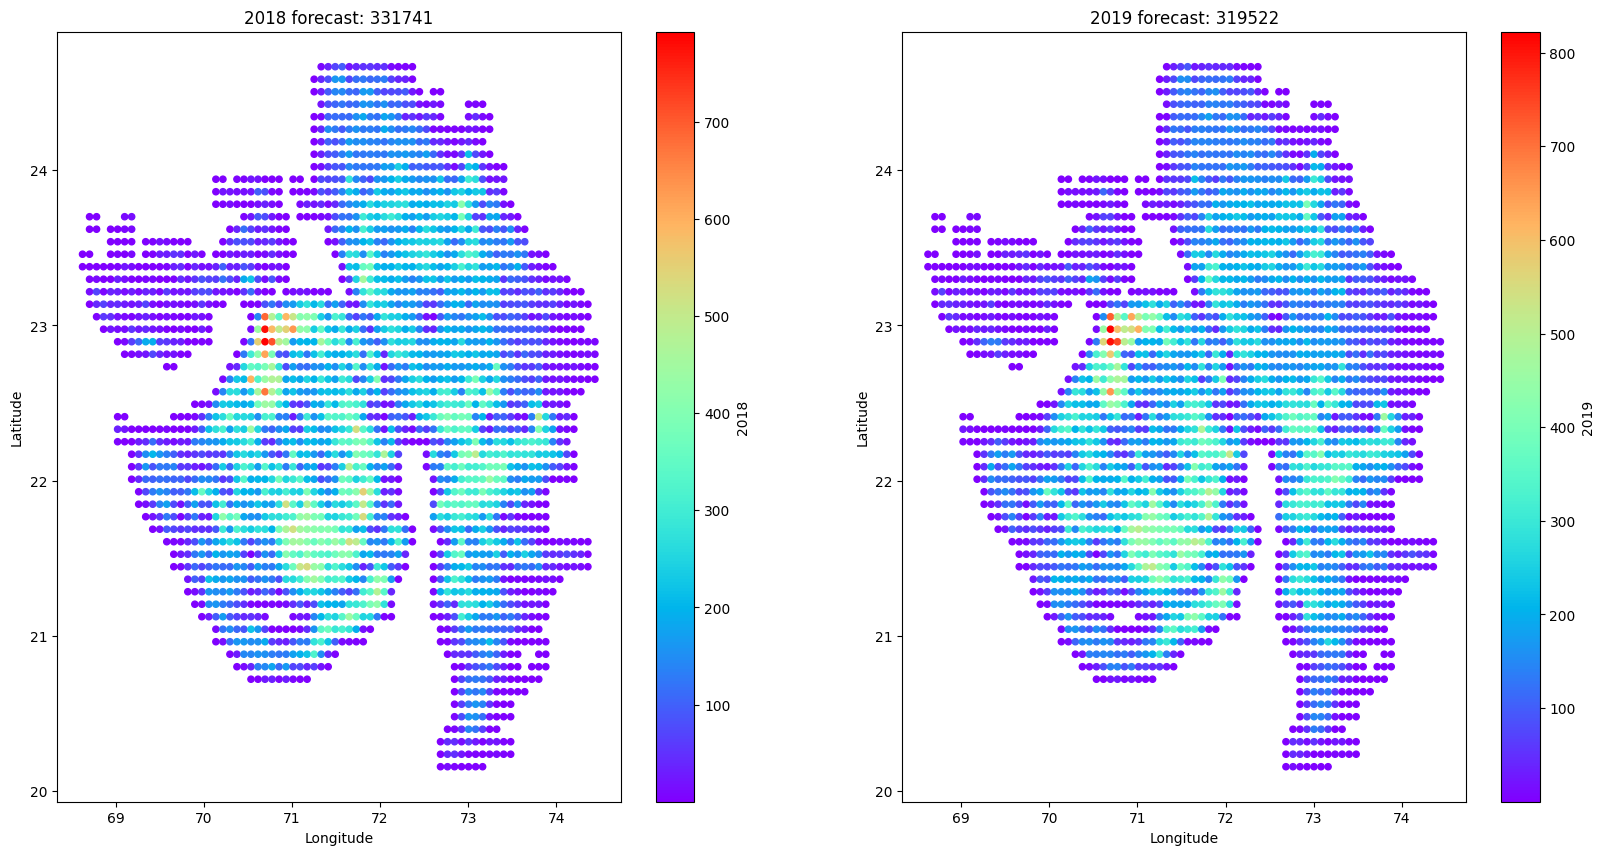

In [ ]:
import os

# Check if the directory exists, if not, create it
directory = "../forecast"
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "forecast_extratrees.csv")

# Now you can save your file in this directory
y_2018, y_2019 = generate_predictions(pipeline, df_final, file_path)

# Print the directory path where the file was saved
print("File saved at:", file_path)

In [ ]:
features_imp=[(i,j) for i,j in zip(df_final.drop(columns=["log_biomass","biomass","year"]).columns,pipeline.steps[1][1].feature_importances_)]

sorted(features_imp, key=lambda x: x[1], reverse=True)

[('cropland', 0.5286834856152035),
 ('Longitude', 0.10768444257575019),
 ('elevation', 0.09183564686911247),
 ('Index', 0.05776853178222989),
 ('Latitude', 0.054742032630842506),
 ('in_district_19', 0.012162481927402116),
 ('count_district', 0.010779567864038483),
 ('in_district_14', 0.010533988015617536),
 ('in_district_12', 0.008107323453354067),
 ('distname', 0.008018670988255445),
 ('in_district_8', 0.00783872078914766),
 ('in_district_0', 0.007788402082686526),
 ('in_district_15', 0.00721120674952514),
 ('production-Rice', 0.006271478298425378),
 ('in_district_9', 0.005909910509534896),
 ('in_district_3', 0.005382611150781616),
 ('in_district_7', 0.005225777291978752),
 ('in_district_2', 0.004848466660039045),
 ('in_district_11', 0.004583166282176467),
 ('production-Castor seed', 0.00455012055146097),
 ('production-Arhar/Tur', 0.0035519988838462586),
 ('production-Sesamum', 0.0032378052679115535),
 ('production-Soyabean', 0.003201201599410285),
 ('production-Rapeseed &Mustard', 0.

In [ ]:
%cd /content/Result/

/content/Result


In [ ]:
forecast=pd.read_csv("/content/forecast/forecast_extratrees.csv")
true=pd.read_csv("/content/drive/MyDrive/dataset/dataset/Biomass_private_databasea91704d.csv")

In [ ]:
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

(32.62335674732259, 43.82557227254984)

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(80.31467574159583, 78.75900259919592)

# Random Forest Regressor


In [ ]:
def train_model_log_rf(df):


    params = {
        'random_state': 42,
            "n_estimators":100,
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Step 1: Scale the data
        ('regressor', RandomForestRegressor(**params))  # Step 2: Train ExtraTreesRegressor
    ])

    results=pd.DataFrame()
    tot_mae=[]
    for y in [2010,2011,2012,2013,2014,2015,2016,2017]:

        df_train=df.loc[(~df.year.isin([2018,2019,y]))&(df["biomass"]),:]
        df_test=df.loc[df.year==y,:]

        X_train=df_train.drop(columns=["log_biomass","biomass","year"])
        y_train=df_train[["log_biomass"]].values.ravel()

        X_test=df_test.drop(columns=["log_biomass","biomass","year"])
        y_test=df_test[["log_biomass"]].values.ravel()

        pipeline.fit(X_train,y_train)

        mae_test=np.abs(10**pipeline.predict(X_test)-10**y_test).mean()
        mae_train=np.abs(10**pipeline.predict(X_train)-10**y_train).mean()
        tot_mae+=[(y,mae_train,mae_test)]
        print(y,mae_train,mae_test)


        df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
        df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)
        results=pd.concat([results,df_test])

    sum_df=pd.DataFrame(tot_mae,columns=["year","mae_train","mae_test"]).T
    sum_df["mean"]=sum_df.mean(axis=1)

    print(sum_df)

    return pipeline,results


In [ ]:
pipeline1,results1= train_model_log_rf(df_final)

2010 8.380418347362614 34.261161298802264


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2011 8.502427030762773 37.814238448364286


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2012 7.854170560700817 52.35062331310794


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2013 8.10026167549885 48.4432868951595


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2014 8.346271837142659 38.15620614855951


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2015 8.307306251107827 38.6207715640416


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2016 7.949239941856478 44.74555981889436


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2017 8.17079607888258 54.5272660150023
                     0            1            2            3            4  \
year       2010.000000  2011.000000  2012.000000  2013.000000  2014.000000   
mae_train     8.380418     8.502427     7.854171     8.100262     8.346272   
mae_test     34.261161    37.814238    52.350623    48.443287    38.156206   

                     5           6            7         mean  
year       2015.000000  2016.00000  2017.000000  2013.500000  
mae_train     8.307306     7.94924     8.170796     8.201361  
mae_test     38.620772    44.74556    54.527266    43.614889  


<ipython-input-35-ee22c0c9f1c6>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-35-ee22c0c9f1c6>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


File saved at: ../forecast/forecast_randomforest.csv


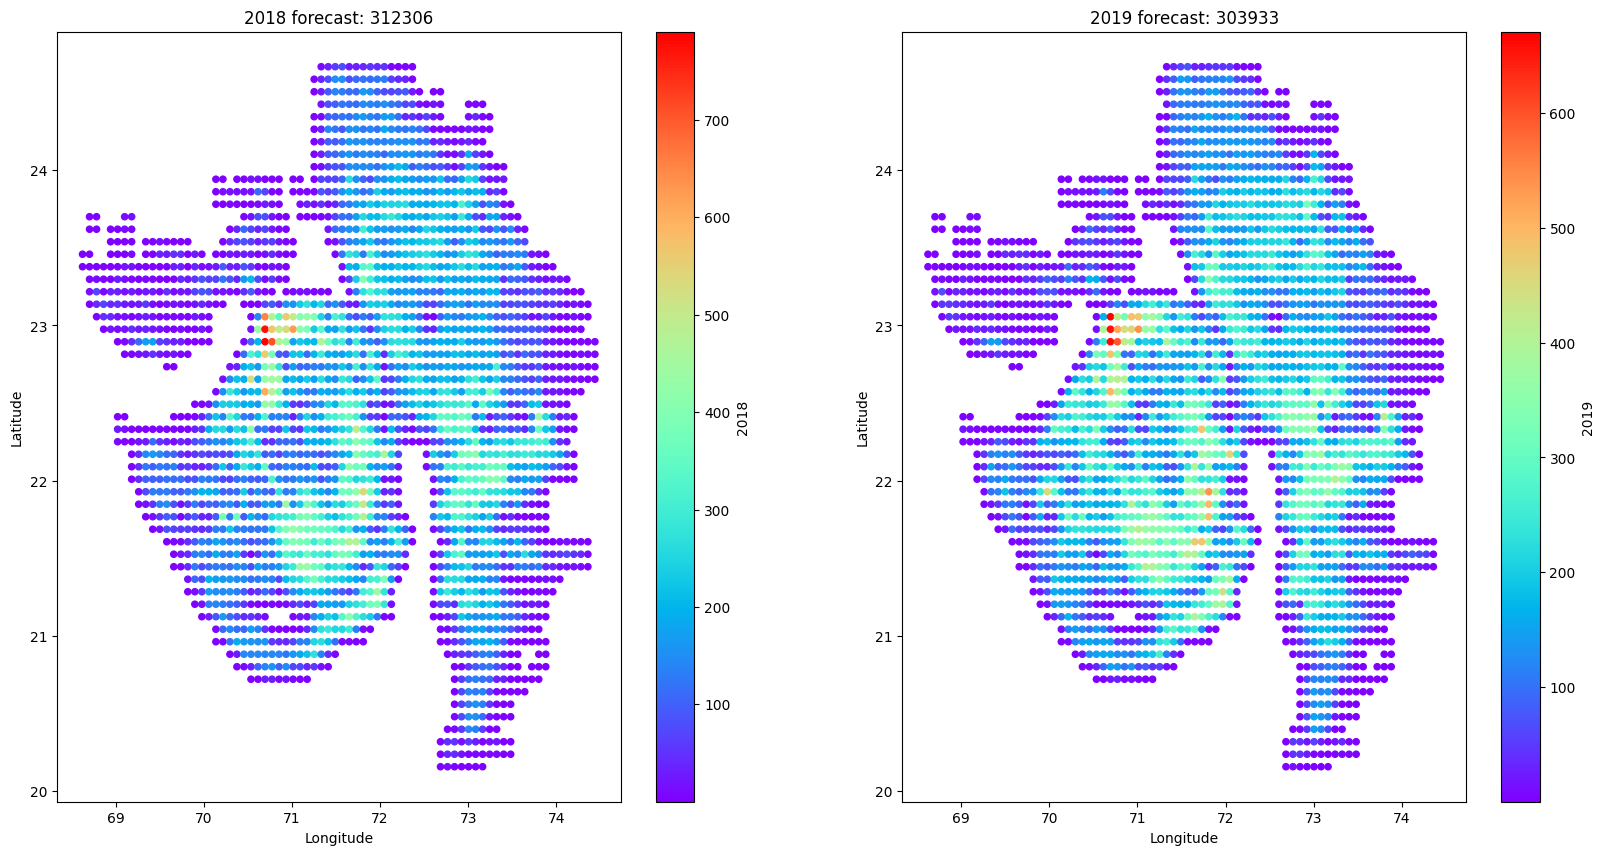

In [ ]:
import os

# Check if the directory exists, if not, create it
directory = "../forecast"
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "forecast_randomforest.csv")

# Now you can save your file in this directory
y_2018, y_2019 = generate_predictions(pipeline1, df_final, file_path)

# Print the directory path where the file was saved
print("File saved at:", file_path)

In [ ]:
features_imp=[(i,j) for i,j in zip(df_final.drop(columns=["log_biomass","biomass","year"]).columns,pipeline1.steps[1][1].feature_importances_)]

sorted(features_imp, key=lambda x: x[1], reverse=True)

[('cropland', 0.5423881106738426),
 ('Longitude', 0.14248022491949575),
 ('Index', 0.10015144514659627),
 ('elevation', 0.08373877109303152),
 ('Latitude', 0.020825108551509458),
 ('count_district', 0.012119907753703517),
 ('production-Rice', 0.008521269697102287),
 ('distname', 0.008105184641281456),
 ('production-Arhar/Tur', 0.006209337933789903),
 ('production-Castor seed', 0.006003637841692743),
 ('production-Bajra', 0.005802770589176522),
 ('district_prod_production-Cotton(lint)_sum', 0.005574105130893947),
 ('in_district_12', 0.0055357747127146445),
 ('production-Groundnut', 0.004175166899319002),
 ('production-Sesamum', 0.004032256502156817),
 ('production-Wheat', 0.0037301043430425164),
 ('production-Moong(Green Gram)', 0.0032983537094467942),
 ('production-Gram', 0.0031823955953230974),
 ('index_cotton_prod_share', 0.0029881196321424426),
 ('production-Jowar', 0.002908754020391398),
 ('total_crop_prod', 0.0028051715114524823),
 ('in_district_14', 0.0026857642238981485),
 ('in_

In [ ]:
forecast=pd.read_csv("/content/forecast/forecast_randomforest.csv")
true=pd.read_csv("/content/drive/MyDrive/dataset/dataset/Biomass_private_databasea91704d.csv")

In [ ]:
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

(31.110473210401317, 45.399449257715496)

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(80.89998012435994, 78.15010107117503)

# GradientBoostingRegressor

In [ ]:
def train_model_log_gb(df):


    params = {
        'random_state': 42,
            "n_estimators":100,
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Step 1: Scale the data
        ('regressor', GradientBoostingRegressor(**params))  # Step 2: Train ExtraTreesRegressor
    ])

    results=pd.DataFrame()
    tot_mae=[]
    for y in [2010,2011,2012,2013,2014,2015,2016,2017]:

        df_train=df.loc[(~df.year.isin([2018,2019,y]))&(df["biomass"]),:]
        df_test=df.loc[df.year==y,:]

        X_train=df_train.drop(columns=["log_biomass","biomass","year"])
        y_train=df_train[["log_biomass"]].values.ravel()

        X_test=df_test.drop(columns=["log_biomass","biomass","year"])
        y_test=df_test[["log_biomass"]].values.ravel()

        pipeline.fit(X_train,y_train)

        mae_test=np.abs(10**pipeline.predict(X_test)-10**y_test).mean()
        mae_train=np.abs(10**pipeline.predict(X_train)-10**y_train).mean()
        tot_mae+=[(y,mae_train,mae_test)]
        print(y,mae_train,mae_test)


        df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
        df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)
        results=pd.concat([results,df_test])

    sum_df=pd.DataFrame(tot_mae,columns=["year","mae_train","mae_test"]).T
    sum_df["mean"]=sum_df.mean(axis=1)

    print(sum_df)

    return pipeline,results


In [ ]:
pipeline2,results2= train_model_log_gb(df_final)

2010 53.2432738498018 57.30845723236568


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2011 52.19761018319436 59.27877293095169


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2012 52.942976761371604 61.157059895910585


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2013 52.098502349265424 68.43850827930937


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2014 52.968191544348144 60.03223735011468


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2015 52.525544046695295 53.90497227447634


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2016 53.11750796311953 54.00063898927364


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2017 51.462423764961976 69.56938077123775
                     0            1            2            3            4  \
year       2010.000000  2011.000000  2012.000000  2013.000000  2014.000000   
mae_train    53.243274    52.197610    52.942977    52.098502    52.968192   
mae_test     57.308457    59.278773    61.157060    68.438508    60.032237   

                     5            6            7         mean  
year       2015.000000  2016.000000  2017.000000  2013.500000  
mae_train    52.525544    53.117508    51.462424    52.569504  
mae_test     53.904972    54.000639    69.569381    60.461253  


<ipython-input-42-116dd7ad37c9>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-42-116dd7ad37c9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


File saved at: ../forecast/forecast_gradientboosting.csv


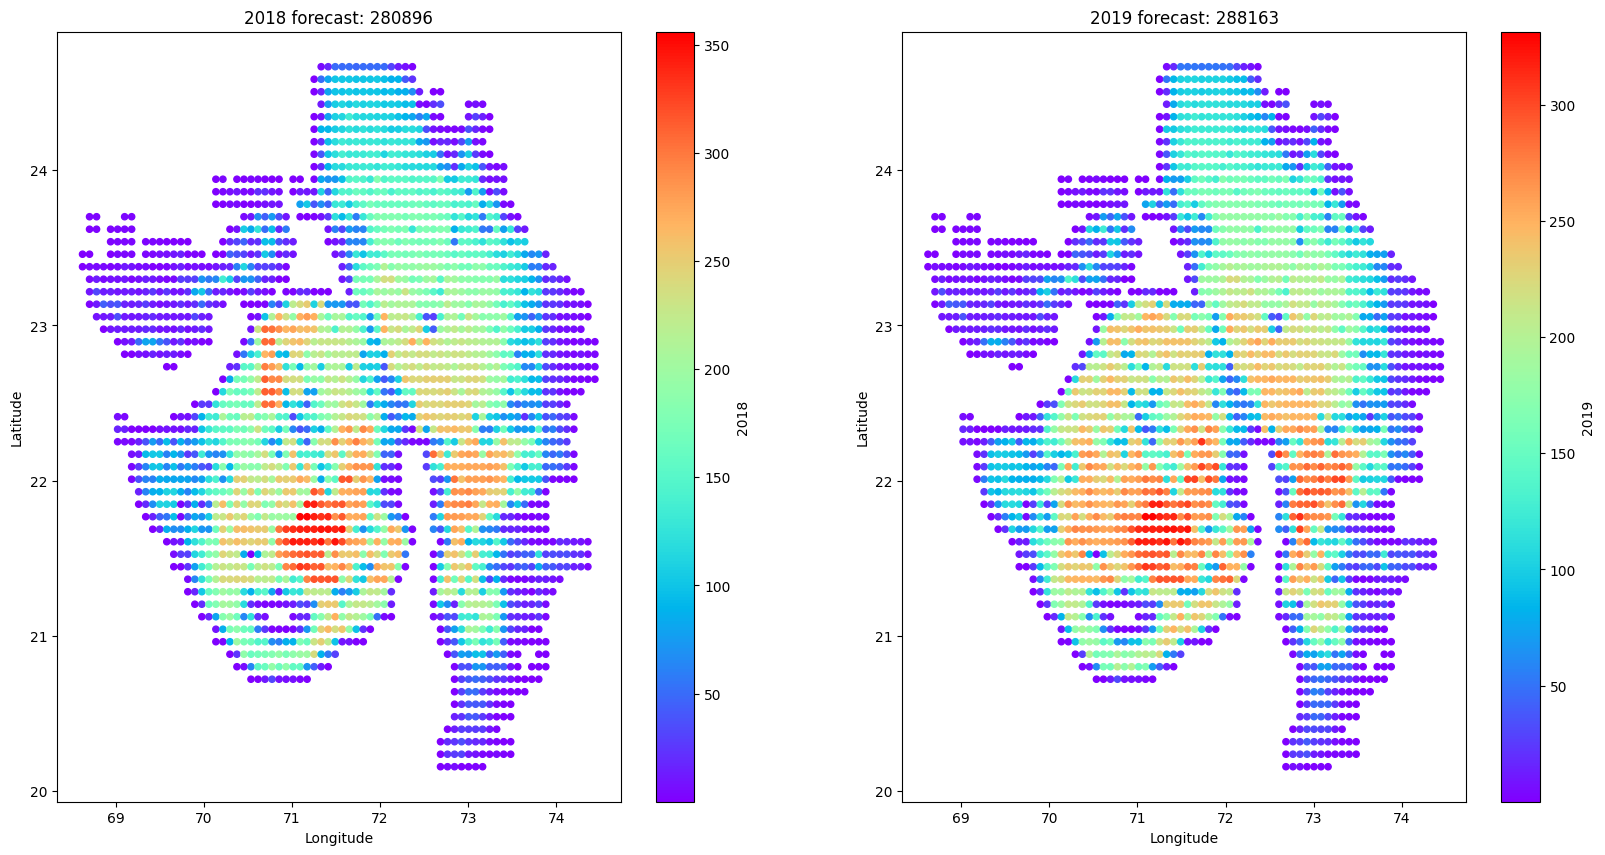

In [ ]:
import os

# Check if the directory exists, if not, create it
directory = "../forecast"
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "forecast_gradientboosting.csv")

# Now you can save your file in this directory
y_2018, y_2019 = generate_predictions(pipeline2, df_final, file_path)

# Print the directory path where the file was saved
print("File saved at:", file_path)

In [ ]:
features_imp=[(i,j) for i,j in zip(df_final.drop(columns=["log_biomass","biomass","year"]).columns,pipeline2.steps[1][1].feature_importances_)]

sorted(features_imp, key=lambda x: x[1], reverse=True)

[('cropland', 0.6241920252888248),
 ('Longitude', 0.14631589995330796),
 ('Index', 0.0866491360297718),
 ('elevation', 0.08524725533534938),
 ('count_district', 0.019376786679032143),
 ('Latitude', 0.006965634544656129),
 ('distname', 0.00406553968192562),
 ('production-Groundnut', 0.003185704490623964),
 ('in_district_12', 0.0030284769105813794),
 ('in_district_14', 0.002373318874492886),
 ('production-Rice', 0.00234462571693026),
 ('production-Castor seed', 0.002305363667738504),
 ('production-Arhar/Tur', 0.0020278915628281044),
 ('production-Bajra', 0.0018694000746150635),
 ('production-Tobacco', 0.0015124965413701767),
 ('production-Wheat', 0.0012534685234675909),
 ('total_crop_prod', 0.0011262114675081878),
 ('production-Sesamum', 0.0011172163837587191),
 ('index_cotton_prod_share', 0.0009611657726180464),
 ('production-Sugarcane', 0.0006682450945230031),
 ('production-Maize', 0.0006532478319635878),
 ('district_prod_production-Cotton(lint)_sum', 0.0006158630882145313),
 ('in_dist

In [ ]:
forecast=pd.read_csv("/content/forecast/forecast_gradientboosting.csv")
true=pd.read_csv("/content/drive/MyDrive/dataset/dataset/Biomass_private_databasea91704d.csv")
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

(42.221480580234754, 63.0840259963285)

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(76.60135359311877, 71.30829202254043)

# AdaBoostRegressor

In [ ]:
def train_model_log_ada(df):


    params = {
        'random_state': 42,
            "n_estimators":100,
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Step 1: Scale the data
        ('regressor', AdaBoostRegressor(**params))  # Step 2: Train ExtraTreesRegressor
    ])

    results=pd.DataFrame()
    tot_mae=[]
    for y in [2010,2011,2012,2013,2014,2015,2016,2017]:

        df_train=df.loc[(~df.year.isin([2018,2019,y]))&(df["biomass"]),:]
        df_test=df.loc[df.year==y,:]

        X_train=df_train.drop(columns=["log_biomass","biomass","year"])
        y_train=df_train[["log_biomass"]].values.ravel()

        X_test=df_test.drop(columns=["log_biomass","biomass","year"])
        y_test=df_test[["log_biomass"]].values.ravel()

        pipeline.fit(X_train,y_train)

        mae_test=np.abs(10**pipeline.predict(X_test)-10**y_test).mean()
        mae_train=np.abs(10**pipeline.predict(X_train)-10**y_train).mean()
        tot_mae+=[(y,mae_train,mae_test)]
        print(y,mae_train,mae_test)


        df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
        df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)
        results=pd.concat([results,df_test])

    sum_df=pd.DataFrame(tot_mae,columns=["year","mae_train","mae_test"]).T
    sum_df["mean"]=sum_df.mean(axis=1)

    print(sum_df)

    return pipeline,results


In [ ]:
pipeline3,results3 = train_model_log_ada(df_final)

2010 126.73788222488517 130.74181825205193


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2011 114.70856099055976 128.21116377150992


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2012 127.41826697454522 87.62574746606516


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2013 121.02274694648558 144.24226326469463


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2014 85.32469299563665 100.20838256937833


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2015 109.98186327008789 101.00324079319097


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2016 125.0683277944329 92.51290988012215


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2017 123.58809943527217 144.80793265809888
                     0            1            2            3            4  \
year       2010.000000  2011.000000  2012.000000  2013.000000  2014.000000   
mae_train   126.737882   114.708561   127.418267   121.022747    85.324693   
mae_test    130.741818   128.211164    87.625747   144.242263   100.208383   

                     5            6            7         mean  
year       2015.000000  2016.000000  2017.000000  2013.500000  
mae_train   109.981863   125.068328   123.588099   116.731305  
mae_test    101.003241    92.512910   144.807933   116.169182  


<ipython-input-48-9769c03a1e52>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-48-9769c03a1e52>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


File saved at: ../forecast/forecast_adaboost.csv


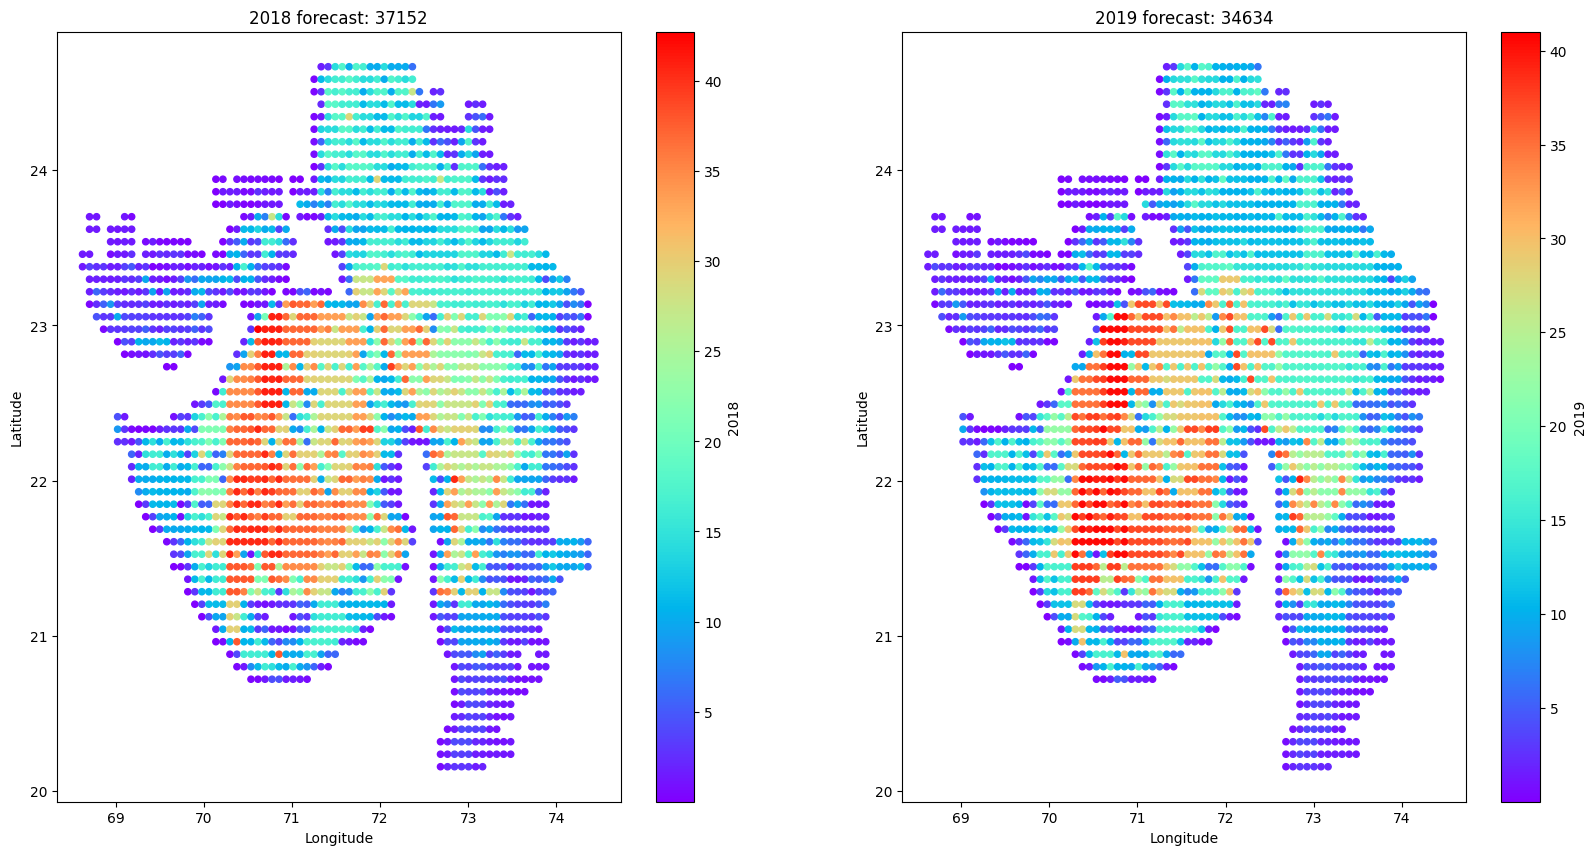

In [ ]:
import os

# Check if the directory exists, if not, create it
directory = "../forecast"
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "forecast_adaboost.csv")

# Now you can save your file in this directory
y_2018, y_2019 = generate_predictions(pipeline3, df_final, file_path)

# Print the directory path where the file was saved
print("File saved at:", file_path)

In [ ]:
features_imp=[(i,j) for i,j in zip(df_final.drop(columns=["log_biomass","biomass","year"]).columns,pipeline3.steps[1][1].feature_importances_)]

sorted(features_imp, key=lambda x: x[1], reverse=True)

[('cropland', 0.3182107225620669),
 ('Longitude', 0.16746244637613844),
 ('Index', 0.13037216239218982),
 ('elevation', 0.11894773264308633),
 ('index_cotton_prod_share', 0.03761084602888925),
 ('Latitude', 0.03274198657956525),
 ('count_district', 0.02410140993442715),
 ('production-Rice', 0.02246618541097701),
 ('distname', 0.019001534669600494),
 ('production-Sesamum', 0.018241242313513165),
 ('total_crop_prod', 0.015009866746366177),
 ('in_district_14', 0.013770969602308367),
 ('production-Maize', 0.012621032970080125),
 ('in_district_12', 0.012127879343455925),
 ('production-Moong(Green Gram)', 0.009681604467313597),
 ('production-Soyabean', 0.008701699635424939),
 ('production-Arhar/Tur', 0.006598938660834937),
 ('production-Bajra', 0.006262201590907689),
 ('production-Jowar', 0.0055213405143986795),
 ('production-Groundnut', 0.0036381045547764787),
 ('production-Cotton(lint)', 0.003255631736468673),
 ('in_district_7', 0.002808987146485137),
 ('production-Castor seed', 0.00264866

In [ ]:
forecast=pd.read_csv("/content/forecast/forecast_adaboost.csv")
true=pd.read_csv("/content/drive/MyDrive/dataset/dataset/Biomass_private_databasea91704d.csv")
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

(99.72966193152041, 140.03489274343528)

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(54.35258839193338, 41.53754069541976)

# HuberRegressor


In [ ]:
def train_model_log_hub(df):


    params = {
        'epsilon': 1.35,
        'max_iter': 100,
        'alpha': 0.0001,
        'tol': 1e-05
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Step 1: Scale the data
        ('regressor', HuberRegressor(**params))  # Step 2: Train ExtraTreesRegressor
    ])

    results=pd.DataFrame()
    tot_mae=[]
    for y in [2010,2011,2012,2013,2014,2015,2016,2017]:

        df_train=df.loc[(~df.year.isin([2018,2019,y]))&(df["biomass"]),:]
        df_test=df.loc[df.year==y,:]

        X_train=df_train.drop(columns=["log_biomass","biomass","year"])
        y_train=df_train[["log_biomass"]].values.ravel()

        X_test=df_test.drop(columns=["log_biomass","biomass","year"])
        y_test=df_test[["log_biomass"]].values.ravel()

        pipeline.fit(X_train,y_train)

        mae_test=np.abs(10**pipeline.predict(X_test)-10**y_test).mean()
        mae_train=np.abs(10**pipeline.predict(X_train)-10**y_train).mean()
        tot_mae+=[(y,mae_train,mae_test)]
        print(y,mae_train,mae_test)


        df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
        df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)
        results=pd.concat([results,df_test])

    sum_df=pd.DataFrame(tot_mae,columns=["year","mae_train","mae_test"]).T
    sum_df["mean"]=sum_df.mean(axis=1)

    print(sum_df)

    return pipeline,results


In [ ]:
pipeline4,results4 = train_model_log_hub(df_final)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
<ipython-input-72-f6b097e1f290>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-72-f6b097e1f290>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

2010 72.75797534495811 82.1095073288801


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
<ipython-input-72-f6b097e1f290>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-72-f6b097e1f290>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

2011 72.61299211678167 84.59744326986252
2012 74.99801475727438 81.73295059882513


<ipython-input-72-f6b097e1f290>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-72-f6b097e1f290>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the

2013 72.37449011037714 89.67178842608658


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
<ipython-input-72-f6b097e1f290>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-72-f6b097e1f290>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

2014 72.09461965959675 79.51184111956954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
<ipython-input-72-f6b097e1f290>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-72-f6b097e1f290>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

2015 74.44995688027635 70.33770134616843
2016 74.86715213988548 68.35829182059027


<ipython-input-72-f6b097e1f290>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-72-f6b097e1f290>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


2017 71.526809130034 86.27362843972172
                     0            1            2            3            4  \
year       2010.000000  2011.000000  2012.000000  2013.000000  2014.000000   
mae_train    72.757975    72.612992    74.998015    72.374490    72.094620   
mae_test     82.109507    84.597443    81.732951    89.671788    79.511841   

                     5            6            7         mean  
year       2015.000000  2016.000000  2017.000000  2013.500000  
mae_train    74.449957    74.867152    71.526809    73.210251  
mae_test     70.337701    68.358292    86.273628    80.324144  


<ipython-input-72-f6b097e1f290>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"pred"]=10**pipeline.predict(X_test)
<ipython-input-72-f6b097e1f290>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,"mae"]=10**y_test-10**pipeline.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


File saved at: ../forecast/forecast_huber.csv


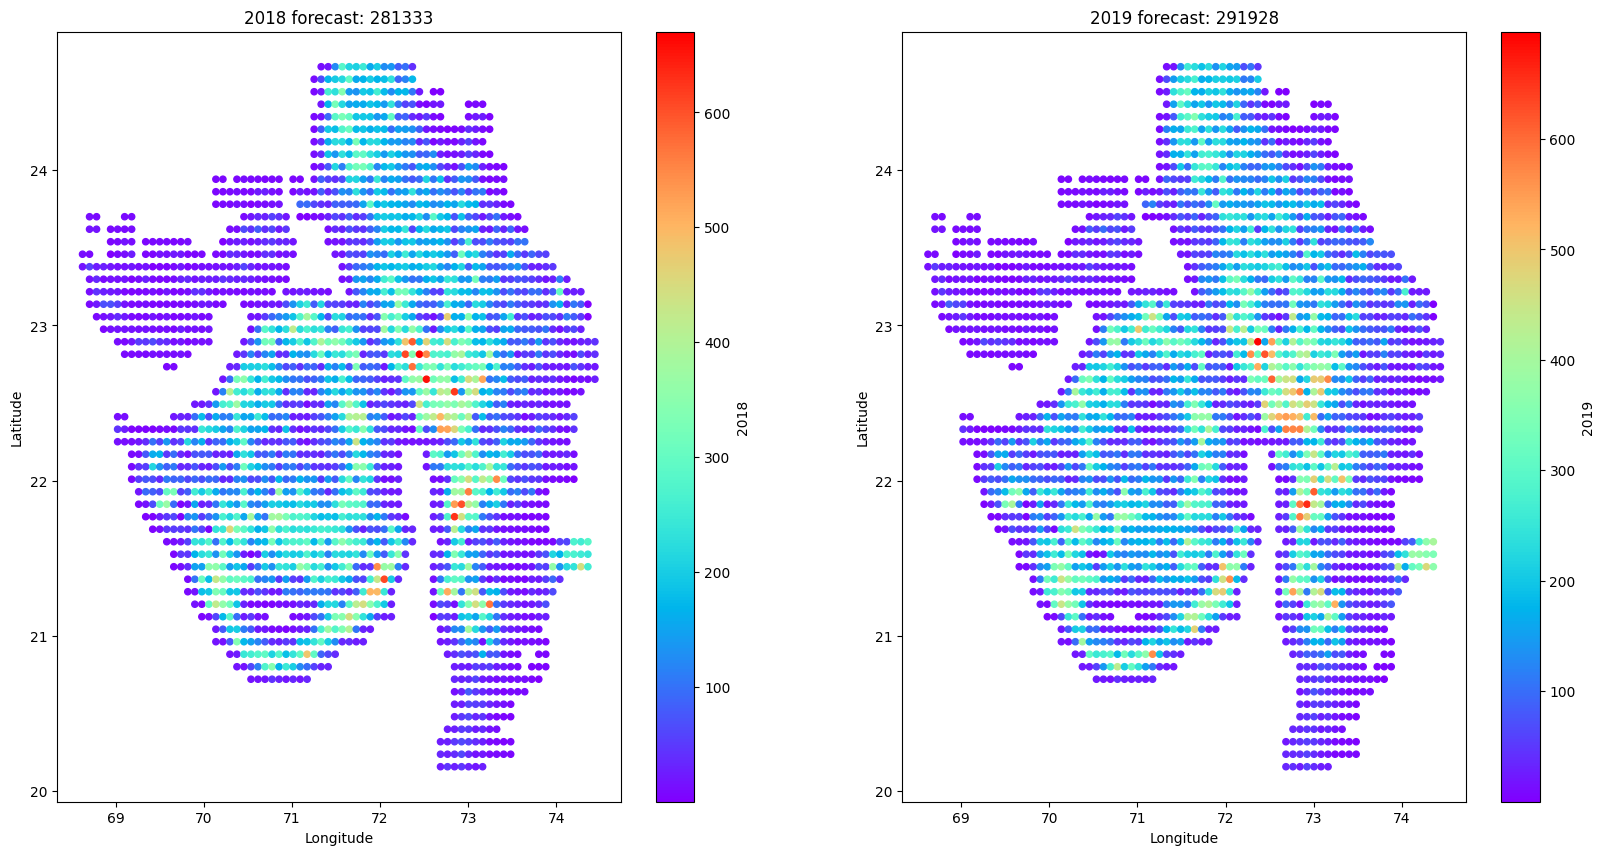

In [ ]:
import os

# Check if the directory exists, if not, create it
directory = "../forecast"
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the file path
file_path = os.path.join(directory, "forecast_huber.csv")

# Now you can save your file in this directory
y_2018, y_2019 = generate_predictions(pipeline4, df_final, file_path)

# Print the directory path where the file was saved
print("File saved at:", file_path)

In [ ]:
forecast=pd.read_csv("/content/forecast/forecast_huber.csv")
true=pd.read_csv("/content/drive/MyDrive/dataset/dataset/Biomass_private_databasea91704d.csv")
forecast_score_2018,forecast_score_2019=np.mean(np.abs(forecast["2018"]-true["2018"])),np.mean(np.abs(forecast["2019"]-true["2019"]))
forecast_score_2018,forecast_score_2019

(57.7656567636463, 89.92016887403886)

In [ ]:
def get_score(forecast_cost,opt_cost):
    return 100-((forecast_cost*2418)+opt_cost)*80/500000
get_score(forecast_score_2018,44150),get_score(forecast_score_2019,26786)

(70.58762271128052, 60.92592506601184)